Setups

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.util import img_as_float, img_as_ubyte
from skimage.transform import resize
from scipy import signal
import splines

zero order B_Spline in the range $x \in [-2, 2]$.

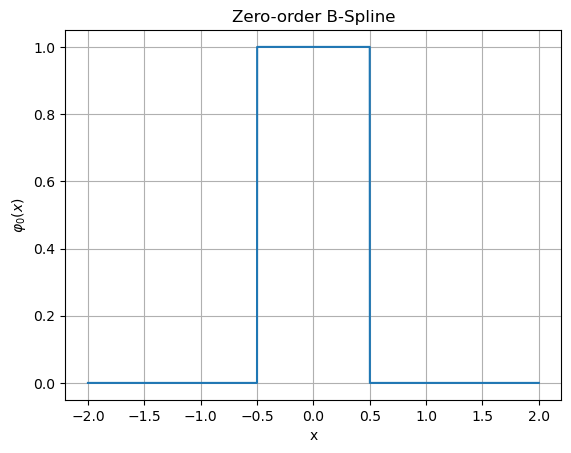

In [2]:
def spline_b0(x):
    y = np.where(np.abs(x) < 0.5, 1, 0)#if smaller than 0.5, return 1, else return 0
    return y

x = np.linspace(-2, 2, 10000)
#plot
plt.plot(x, spline_b0(x))
plt.title('Zero-order B-Spline')
plt.xlabel('x')
plt.ylabel(r'$\varphi_0(x)$')#LaTex function for φ0(x)
plt.grid()
plt.show()

N-order B-Spline

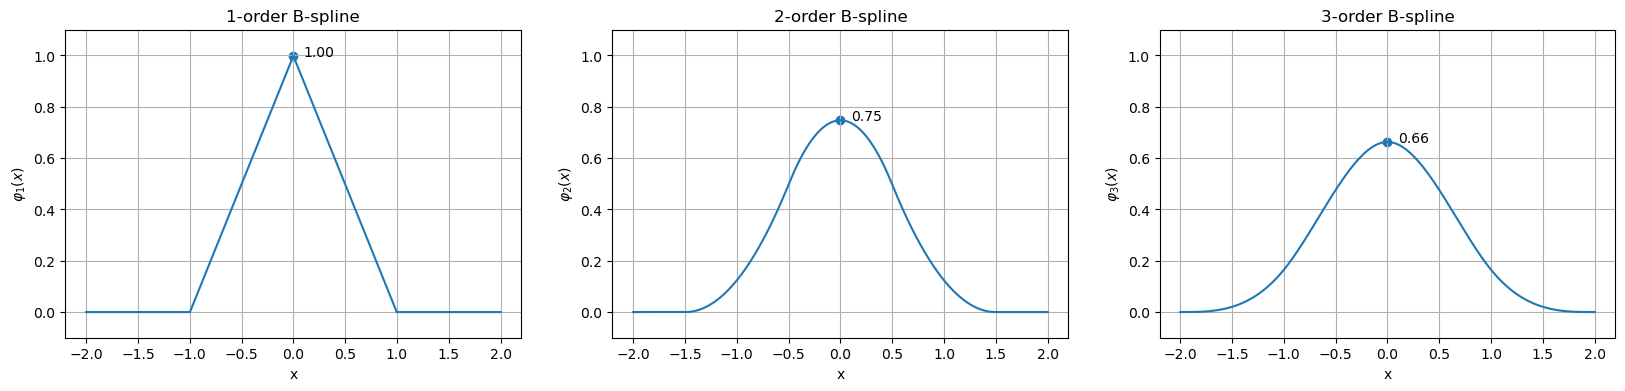

In [3]:
def spline_bn(x, n):
    if n == 0:
        return spline_b0(x)
    else:
        return np.convolve(spline_b0(x), spline_bn(x, n-1), 'same')#'same' keeps the length match the original
    
N = 1000
x = np.linspace(-2, 2, 2 * N + 1)
dx = x[1] - x[0]#step size
fix, axs = plt.subplots(1, 3, figsize=(20, 4))
for i, n in enumerate(range(1, 4)):#i is the index, n is the order
    phi_n = spline_bn(x, n) * np.power(dx, n)
    axs[i].plot(x, phi_n)
    axs[i].scatter(x[N], phi_n[N])
    axs[i].text(x[N] + 0.1, phi_n[N], f"{phi_n[N]:.2f}")
    axs[i].set_title(f"{n}-order B-spline")
    axs[i].set_xlabel("x")
    axs[i].set_ylabel(f"$\\varphi_{n}(x)$")
    axs[i].grid()
    axs[i].set_ylim(-0.1, 1.1)
plt.show()

Write a function `weighted_splines(coeffs, x, n)` that calculates the weighted superposition of the appropriately shifted `n`-th order B-splines based on the spline coefficients `coeffs` at the sampling positions `x` as

$$ y(x) = \sum_i c_i \varphi_n(x - i), $$

where $y$ are the sampled (interpolated) signal values, $c_i$ are the spline coefficients and $\varphi_n$ is the n-th order B-spline basis function.

In [4]:
def spline_func(n):
    if n == 0:
        return spline_b0
    elif n == 1:
        return splines.spline_b1
    elif n == 2:
        return splines.spline_b2
    elif n == 3:
        return splines.spline_b3
    else:
        raise RuntimeError("Unsupported spline order.")#call the error when meet wrong order

def weighted_splines(coeffs, x, n):
    spline = spline_func(n)
    y = np.zeros(x.shape[0])
    for i, coeff in enumerate(coeffs):
        y += coeff * spline(x - i)
    return y

Write a function `spline_coeffs(y, n)` that calculates the spline coefficients for `n`-th order B-spline basis functions given the sampled signal values `y` based on

$$ \mathbf{y} = \mathbf{A} \mathbf{c}. $$

Setup the constraint matrix $\mathbf{A}$ for the n-th order B-spline and solve for the unknown spline coefficients $\mathbf{c}$. The constraint matrix is setup such that the available samples $\mathbf{y}$ are exactly reconstruced by the weighted superposition of the B-splines.

In [5]:
def spline_coeffs(y, n):
    spline = spline_func(n)
    N = y.shape[0]
    x = np.arange(0, N)
    A = np.empty((N, N))
    for i in range(N):
        A[i, :] = spline(x - i)
    coeffs = np.linalg.inv(A).dot(y)
    return coeffs

upsampling the image

In [6]:
#read the image
image = color.rgb2gray(img_as_float(io.imread('data/resources/zebra.jpg')))
#change the size
image = resize(image, (72, 108), anti_aliasing=True)

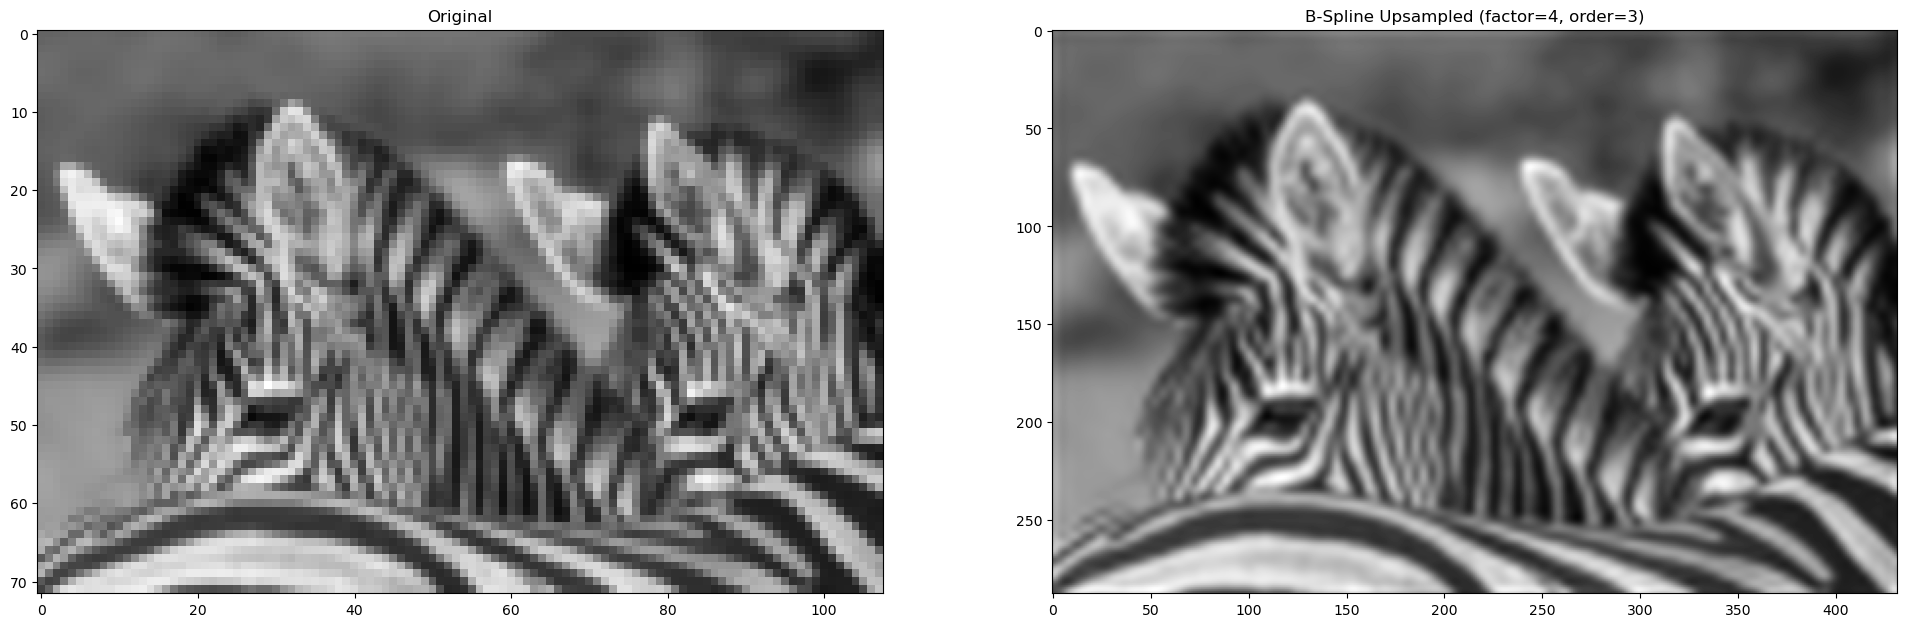

In [7]:
factor = 4#upsampling factor
order = 3
image_interp = np.zeros((factor * image.shape[0], factor * image.shape[1]))
x = np.linspace(0, image.shape[1] - 1, image.shape[1] * factor)
for i in range(image.shape[0]):
    coeffs = spline_coeffs(image[i, :], order)
    image_interp[factor * i, :] = weighted_splines(coeffs, x, order)
    
x = np.linspace(0, image.shape[0] - 1, image.shape[0] * factor)
for j in range(image_interp.shape[1]):
    coeffs = spline_coeffs(image_interp[::factor, j], order)
    image_interp[:, j] = weighted_splines(coeffs, x, order)
    
fig, axs = plt.subplots(1, 2, figsize=(24, 16))
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original")
axs[1].imshow(image_interp, cmap='gray')
axs[1].set_title(f"B-Spline Upsampled (factor={factor}, order={order})")
plt.show()

use state-of-the-art EDSR network (neural network) do the superresolution

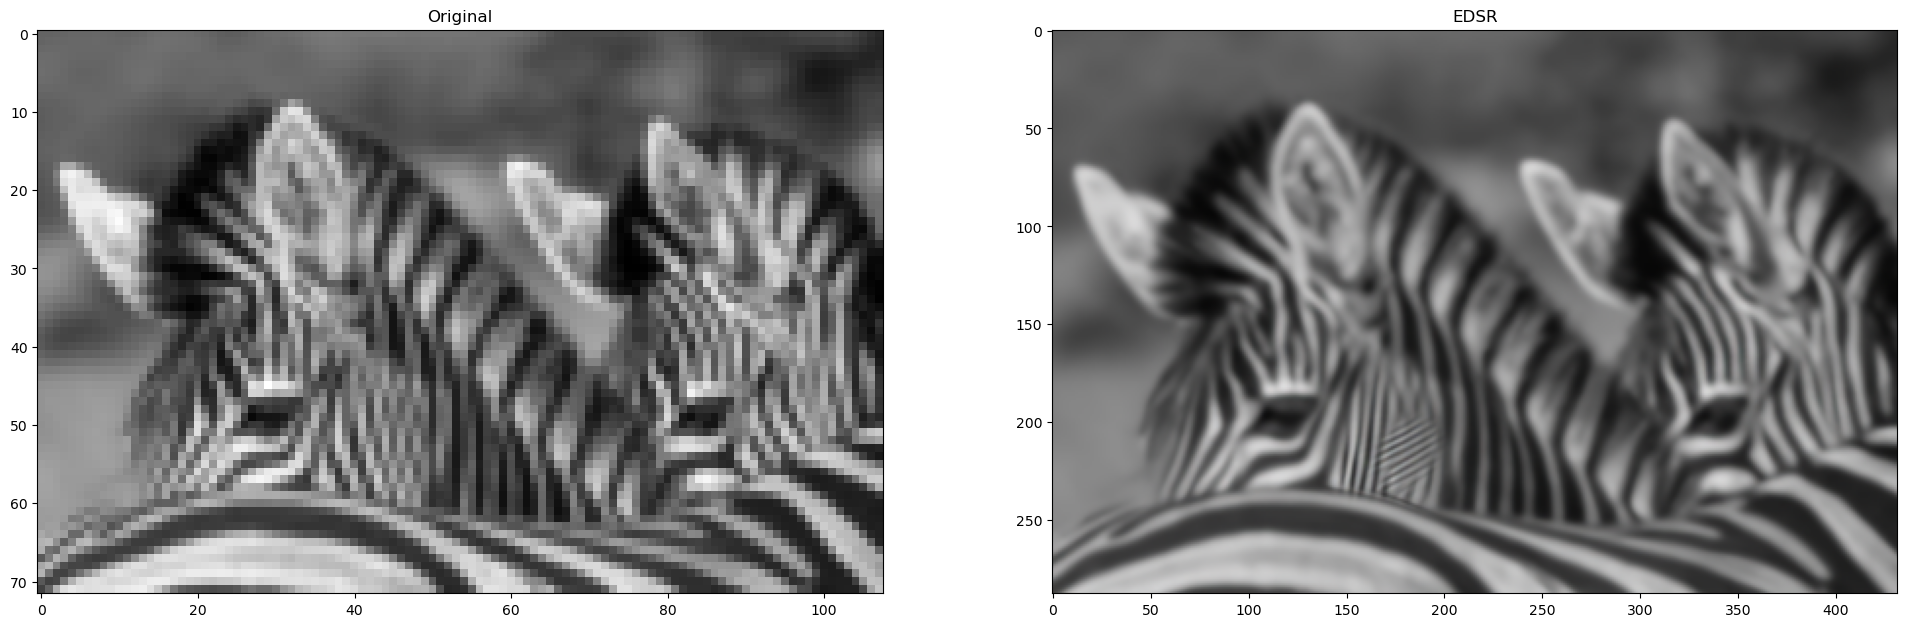

In [8]:
import cv2

sr = cv2.dnn_superres.DnnSuperResImpl_create()#here create a object for the superresolution model
sr.readModel("data/resources/EDSR_x4.pb")#call the model in the resource
sr.setModel("edsr", 4)

image_bgr_uint8 = img_as_ubyte(color.gray2rgb(image))[:, :, ::-1]
image_sr = sr.upsample(image_bgr_uint8)[:, :, ::-1]

fig, axs = plt.subplots(1, 2, figsize=(24, 16))
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original")
axs[1].imshow(image_sr)
axs[1].set_title("EDSR")
plt.show()

In [9]:
#check the version of opencv, may have problem with version or dnn_superres command
import cv2
print(cv2.__version__)

4.10.0
